In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torchvision.transforms as transforms
import  torch
import  numpy as np
import learn2learn as l2l
import matplotlib.pyplot as plt
import sys
import umap

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from kmeans_pytorch import kmeans, kmeans_predict
from learn2learn.data.transforms import (NWays,
                                         KShots,
                                         LoadData,
                                         RemapLabels,
                                         ConsecutiveLabels)
from learn2learn.data.utils import partition_task,  InfiniteIterator, OnDeviceDataset
from tqdm import tqdm 
from torch.utils.data import Dataset, DataLoader
from Miniimagenet import MiniImagenet as Mini
from torch import nn
from torch import optim
from torch.nn import functional as F
from MiniImagenet import miniImageNetGenerator as MiniImagenet

k_spt = 1
num_task = 100

train_set = Mini("/data01/jjlee_hdd/data", mode="train")
val_set = Mini("/data01/jjlee_hdd/data", mode="validation")
test_set = Mini("/data01/jjlee_hdd/data", mode="test")

train_dataset = l2l.data.MetaDataset(train_set)
val_dataset = l2l.data.MetaDataset(val_set)
test_dataset = l2l.data.MetaDataset(test_set)

train_transforms = [
   NWays(train_dataset, n = 5),
   KShots(train_dataset, k = k_spt*2),
   LoadData(train_dataset),
   # RemapLabels(train_dataset),
   ConsecutiveLabels(train_dataset)
   ]
val_transforms = [
   NWays(val_dataset, 5),
   KShots(val_dataset, k_spt*2),
   LoadData(val_dataset),
   # RemapLabels(val_dataset),
   # ConsecutiveLabels(val_dataset)
   ]
test_transforms = [
   NWays(test_dataset, 5),
   KShots(test_dataset, k_spt*2),
   LoadData(test_dataset),
   # RemapLabels(test_dataset),
   # ConsecutiveLabels(test_dataset)
   ]
    
train_tasks = l2l.data.TaskDataset(train_dataset, task_transforms = train_transforms, num_tasks=num_task)
val_tasks = l2l.data.TaskDataset(val_dataset, task_transforms = val_transforms, num_tasks=num_task)
test_tasks = l2l.data.TaskDataset(test_dataset, task_transforms = test_transforms, num_tasks=100)

train_loader = DataLoader(train_tasks,pin_memory=True, shuffle = True)
val_loader = DataLoader(val_tasks, pin_memory=True, shuffle = True)
test_loader = DataLoader(test_tasks, pin_memory=True, shuffle = True)



/home/jjlee/anaconda3/envs/MAML/lib/python3.9/site-packages/learn2learn/vision/benchmarks/omniglot_benchmark.py:7: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  from PIL.Image import LANCZOS


In [3]:
sys.path.append("/home/jjlee/.cache/torch/hub/facebookresearch_dino_main/")
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname("vision_transformer.py"))))

In [2]:
# import vision_transformer

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"


# model = torch.load("/data01/jjlee_hdd/backbone_model/embedding_ViT_euclidean.pt")
model = torch.load("/data01/jjlee_hdd/backbone_model/embedding_ResNet.pt")
classifier = torch.load("/data01/jjlee_hdd/backbone_model/embedding_classifier.pt")
device = torch.device("cuda")

train_results = []
labels = []
# vitb16 = torch.hub.load('facebookresearch/dino:main', 'dino_vitb16').to(device)

model.eval()
with torch.no_grad():
    for i in tqdm(range(num_task), desc="check"):
        # x, y = next(iter(val_loader))
        x_n, y_n = next(iter(train_loader))
        # (x_spt, y_spt), (x_qry, y_qry) = partition_task(x[0], y[0], shots=k_spt)
        (x_spt_n, y_spt_n), (x_qry_n, y_qry_n) = partition_task(x_n[0], y_n[0], shots=k_spt)
        new_model = torch.mean(model(x_spt_n.to(device)), dim=0).cpu().numpy()
        logits = classifier(new_model)
        train_results.append(np.array(logits))
        
train_results = torch.from_numpy(np.array(train_results))
print(train_results.size())

AttributeError: Can't get attribute 'Classifier' on <module '__main__'>

In [32]:
from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2, random_state=42)
# embedding = tsne.fit_transform(train_results)

# pca = PCA(n_components=2, random_state=42) 
# embedding = pca.fit_transform(train_results)

reducer = umap.UMAP(n_neighbors=15,  n_components=2, random_state=42)
embedding = reducer.fit_transform(train_results)


/home/jjlee/anaconda3/envs/MAML/lib/python3.9/site-packages/numba/core/typed_passes.py:329: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../anaconda3/envs/MAML/lib/python3.9/site-packages/umap/umap_.py", line 422:
    @numba.njit(parallel=True)
    def nn_descent(data, n_neighbors, rng_state, max_candidates=50,
    ^

  warnings.warn(errors.NumbaPerformanceWarning(msg,


In [33]:
new = torch.from_numpy(embedding)


In [5]:
# cluster_ids_x, cluster_centers = kmeans(X=new, num_clusters=5, distance='cosine', device=device,tol=1e-15)

cluster_ids_x, cluster_centers = kmeans(X=(train_results), num_clusters=5, distance='euclidean', device=device,tol=1e-15)


running k-means on cuda..


[running kmeans]: 4it [00:00, 78.61it/s, center_shift=0.000000, iteration=4, tol=0.000000]


In [11]:
new_centroid = cluster_centers.view([cluster_centers.size(0),768])
torch.save(new_centroid, "./centroid.pt")

In [12]:
import torch 
b = torch.load('./centroid.pt')
print(b.size())

torch.Size([4, 768])


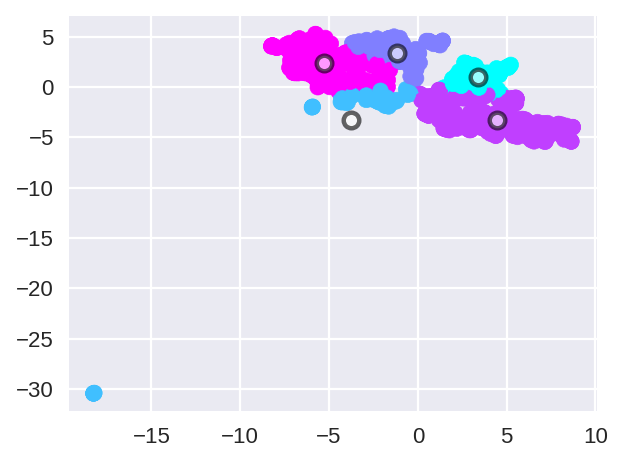

In [35]:
import matplotlib.pyplot as plt

plt.style.use('seaborn')
plt.figure(figsize=(4, 3), dpi=160)
# plt.scatter(train_results[:, 0], train_results[:, 1],c=cluster_ids_x,cmap='cool')
# plt.scatter(
#     cluster_centers[:, 0], cluster_centers[:, 1],
#     c='white',
#     alpha=0.6,
#     edgecolors='black',
#     linewidths=2
# )
plt.scatter(new[:, 0], new[:, 1], c=cluster_ids_x, cmap='cool')
plt.scatter(
    cluster_centers[:, 0], cluster_centers[:, 1],
    c='white',
    alpha=0.6,
    edgecolors='black',
    linewidths=2
)

# i = 0.5
# plt.axis([-i, i, -i, i])
plt.tight_layout()
plt.show()

In [32]:
from xgboost import XGBClassifier
tree = XGBClassifier(seed=2020)
tree.fit(new, cluster_ids_x)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=2020, reg_alpha=0, ...)

In [ ]:
test_results = []
test_labels = []

model.eval()
with torch.no_grad():
    for img in tqdm(range(100)):
        x, y = next(iter(val_loader))
        (x_spt, y_spt), (x_qry, y_qry) = partition_task(x[0], y[0], shots=k_spt)
        new_model = model(x_spt.to(device)).cpu().numpy()
        # print(new_model.shape)
        # new =linear(new_model)
        # print(new)
        test_results.append(np.array(new_model))
        # print(torch.mean(model(x_spt.to(device)), axis=0).shape, y_spt.size())
        test_labels.append(y_spt.cpu().numpy())
# print(len(train_results))         
test_results = torch.from_numpy(np.array(test_results))
labels = torch.from_numpy(np.array(test_labels))

plt.figure(figsize=(15, 10), facecolor="azure")
plt.scatter(test_results[:, 0], test_results[:, 1])
test_results.shape

In [10]:
label = tree.predict(new2)


In [14]:
cluster_ids_x2.size()

torch.Size([100])

In [16]:
count = 0
for i in range(len(label)):
    if (label[i] == cluster_ids_x2[i]):
        count += 1

print(count)

5
